In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter
import random
import cv2


# Mixed Precision 설정 (Apple Silicon에서 성능 향상)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')  # 반정밀도 설정

In [2]:
# MobileNetV2 모델 사용, 입력 크기는 300x300
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

In [3]:
# 추가 레이어 쌓기
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid', dtype='float32')  # 이진 분류, 마지막 출력은 float32로 유지
])

In [4]:
# 모델 컴파일
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [5]:
# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ModelCheckpoint 콜백 설정
checkpoint = ModelCheckpoint(
    'best_model.keras',  # 저장할 파일 이름
    monitor='val_loss',  # val_loss가 가장 낮을 때 저장
    save_best_only=True,  # 가장 성능이 좋은 모델만 저장
    mode='min',  # 손실이 낮을수록 좋으므로 'min' 모드 사용
    verbose=1  # 모델이 저장될 때마다 로그 출력
)

In [6]:
# 특정 각도로 이미지를 회전시키는 함수

def rotate_image(image):
    # 회전 각도를 무작위 선택
    angle = random.choice([45, 90])
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    # 회전 행렬 구하기
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (w, h))
    return rotated_image

In [7]:
train_dir = './dataset/horse-or-human/train/'

# 데이터 증강을 위한 ImageDataGenerator 설정
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1 / 255,  # 0~1 사이로 픽셀 값 정규화
    zoom_range=0.5,  # 최대 50% 무작위 확대 또는 축소
    horizontal_flip=True,  # 좌우반전 무작위
    vertical_flip=True,
    fill_mode="nearest",  # 변환 시 빈공간 주변 픽셀값으로 채움
    preprocessing_function=rotate_image,  # 사용자 정의함수 기반 회전
    validation_split=0.2,  # 검증 데이터 20% 비율
)
# train set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),  # 해상도 조절
    batch_size=32,  # 배치 크기
    class_mode="binary",  # 분류 방법
    subset="training",
)
# valid set
valid_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode="binary",
    subset="validation",
)

# 각 클래스의 이미지 개수 확인
class_counts = Counter(train_generator.classes)
print("클래스별 이미지 개수:", class_counts)

# 총 이미지 개수
total_images = sum(class_counts.values())

# 클래스별로 가중치 설정 (이미지 개수가 적은 클래스에 더 높은 가중치 부여)
class_weights = {
    0: total_images / class_counts[0],  # 말 클래스에 대한 가중치
    1: total_images / class_counts[1],  # 사람 클래스에 대한 가중치
}

print("클래스 가중치:", class_weights)

Found 822 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
클래스별 이미지 개수: Counter({1: 422, 0: 400})
클래스 가중치: {0: 2.055, 1: 1.947867298578199}


In [8]:
# 모델 학습 (훈련/검증 데이터 사용)
history = model.fit(
    train_generator,
    steps_per_epoch=8,  # 전체 훈련 데이터 사용
    epochs=5,  # 최대 20 에포크
    callbacks=[early_stopping, checkpoint],
    class_weight=class_weights  # 클래스별 가중치 적용
)  # 조기 종료 및 체크포인트 콜백 추가

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 91s 7s/step - accuracy: 0.7599 - loss: 1.0017
Epoch 2/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 8s/step - accuracy: 0.9730 - loss: 0.1386
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.9604 - loss: 0.4136
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9414 - loss: 0.3223  
Epoch 5/5


2024-09-06 16:14:32.364005: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 10s/step - accuracy: 0.9549 - loss: 0.3081


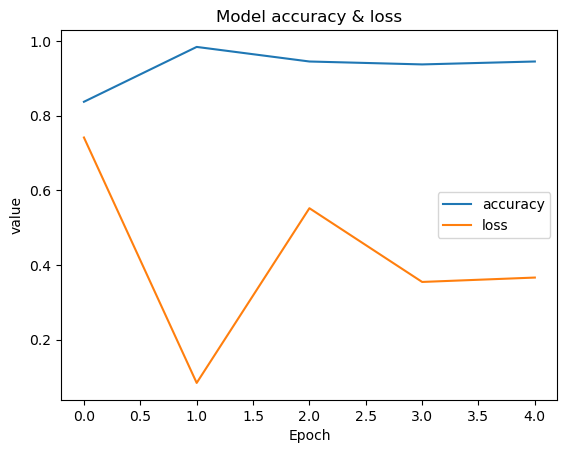

In [9]:
from matplotlib import pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(['accuracy', 'loss'], loc='center right')
plt.show()

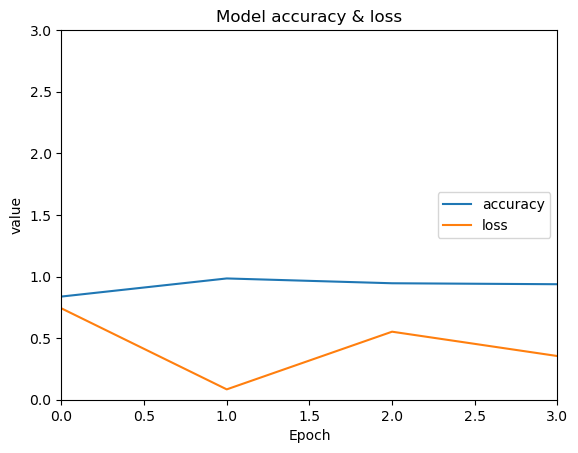

In [11]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
# plt.plot(history.history["val_accuracy"])
# plt.plot(history.history["val_loss"])

plt.title("Model accuracy & loss")
plt.xlabel("Epoch")
plt.ylabel("value")
plt.legend(
    ["accuracy", "loss", "Validation Accuracy", "Validation Loss"], loc="center right"
)
plt.xlim((0,3))
plt.ylim(0,3)
plt.show()

In [12]:
import os
import cv2
import numpy as np
# 이미지 경로 설정
dlist = './dataset/horse-or-human/test/'
predict_list = [f for f in os.listdir(dlist) if f.lower().endswith(('jpg', 'jpeg', 'png', 'webp'))]  # 이미지 파일만 선택

# 실제 레이블 설정 (파일 이름에 따라 설정)
true_labels = []
for file_name in predict_list:
    if "human" in file_name or "사람" in file_name:  # 사람을 나타내는 파일명에 따라 레이블 설정
        true_labels.append(1)
    elif "horse" in file_name or "말" in file_name:  # 말을 나타내는 파일명에 따라 레이블 설정
        true_labels.append(0)
        
print(len(true_labels),len(predict_list))

# 실제 레이블과 예측할 이미지 개수가 일치하는지 확인
assert len(true_labels) == len(predict_list), "레이블과 이미지 파일 개수가 일치하지 않습니다."

# 이미지 전처리
img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (300, 300)) for i in img]  # 모델 입력 크기에 맞게 이미지 크기 조정
img = np.array(img)
img = img.astype('float32') / 255.0  # 정규화

# 분류
cutoff = 0.5
predictions = model.predict(img)

# 예측 결과 출력 및 맞춘 비율 계산
correct_count = 0
total_count = len(predictions)

for idx, prediction in enumerate(predictions):
    file_name = predict_list[idx]
    confidence = float(prediction)  # 예측 확률 (맞춤 비율)
    predicted_label = 1 if confidence >= cutoff else 0  # cutoff에 따른 예측 레이블
    
    # 실제 레이블과 예측 레이블을 비교
    if predicted_label == true_labels[idx]:
        correct_count += 1  # 맞춘 경우 카운트 증가
    
    # 파일 이름과 확률 출력
    if predicted_label == 1:
        print(f"{file_name}: 사람, 확률: {confidence:.2f}")
    else:
        print(f"{file_name}: 말, 확률: {1 - confidence:.2f}")

# 전체 맞춘 비율 (정확도) 계산
accuracy = correct_count / total_count
print(f"\n전체 맞춘 비율(정확도): {accuracy * 100:.2f}%")

32 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
horse_15.webp: 사람, 확률: 0.99
horse_16.jpg: 사람, 확률: 0.99
horse_13.webp: 사람, 확률: 0.99
horse_17.jpg: 사람, 확률: 0.99
horse_14.jpg: 사람, 확률: 0.99
human_08.jpg: 사람, 확률: 0.99
horse_04.jpg: 사람, 확률: 0.99
horse_10.jpg: 사람, 확률: 0.99
human1.jpg: 사람, 확률: 0.99
horse_11.jpg: 사람, 확률: 0.99
horse_05.jpg: 사람, 확률: 0.99
horse_07.jpg: 사람, 확률: 0.99
human2.jpg: 사람, 확률: 0.99
horse_01.jpeg: 사람, 확률: 0.99
horse_06.jpg: 사람, 확률: 0.99
horse_12.jpg: 사람, 확률: 0.99
human_07.jpg: 사람, 확률: 0.99
horse_23.jpg: 사람, 확률: 0.99
horse_02.jpeg: 사람, 확률: 0.99
horse_22.jpg: 사람, 확률: 0.99
human_06.jpg: 사람, 확률: 0.99
horse_20.jpg: 사람, 확률: 0.99
horse_08.jpg: 사람, 확률: 0.99
horse_09.jpg: 사람, 확률: 0.99
horse_21.jpg: 사람, 확률: 0.99
human_05.jpg: 사람, 확률: 0.99
human_01.jpg: 사람, 확률: 0.99
horse_19.jpg: 사람, 확률: 0.99
horse_18.jpg: 사람, 확률: 0.99
human_02.jpg: 사람, 확률: 0.99
horse_03.jpeg: 사람, 확률: 0.99
human_03.jpg: 사람, 확률: 0.99

전체 맞춘 비율(정확도): 28.12%


/var/folders/dn/kpsvhr056zz6gvcnmgrkklzr0000gn/T/ipykernel_71910/1299690837.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction)  # 예측 확률 (맞춤 비율)
